## NLP SENTIMENT ANALYSIS

PHASE FOUR PROJECT - GROUP 8

Authors
* Pamela Godia

* Austine Otieno

* Allan Ofula


## 1. INTRODUCTON

This project aims to automate sentiment classification of tweets using natural language processing (NLP) and machine learning. Using the large-scale Sentiment140 dataset, we build a model to classify tweets as positive or negative, enabling businesses to monitor customer feedback and public sentiment in real time. The approach includes data cleaning, TF-IDF vectorization, and Logistic Regression modeling. It provides a scalable, interpretable foundation for deeper NLP applications, with the potential to integrate advanced models in future stages.

## 1.1 PROJECT OVERVIEW 

## 1.1.1 BUSINESS UNDERSTANDING 

This project focuses on sentiment classification of tweets to help businesses monitor public opinion. The primary use case is for customer service and brand reputation management, where companies can proactively respond to negative sentiments or amplify positive feedback.
## Objective 
- Develop an automated system to classify tweets as positive or negative. Thus, the organization can:

  * Proactively address negative feedback

  * Monitor public perception of campaigns

  * Amplify positive engagement

  * Reduce churn by acting on sentiment early

## 1.1.2 BUSINESS PROBLEM 

Companies need to understand how customers feel about their products and services in real-time. Manually reviewing tweets is not scalable, and using rule-based systems often fails due to the complexity and informality of human language on social media (e.g., slang, sarcasm, emojis).

## 1.1.3 KEY BUSINESS QUESTIONS 

* Can we accurately predict the sentiment of a tweet using its text content alone?

* What are the most frequent words associated with each sentiment?

* How well can a classical model (like Logistic Regression) perform compared to more complex alternatives?

* What preprocessing steps are most effective for handling noisy, short-form social media text?

* Is the model accurate and interpretable enough to deploy for real-time use?

## 2. DATA UNDERSTANDING 

* Dataset: [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140):

* 1.6 million pre-labeled tweets from a sentiment analysis corpus.

* Columns: target (label), ids, date, flag, user, text

* Label Distribution: Balanced (50% positive, 50% negative)

* Unique Users: ~660K

* Tweet Length: Varies; preprocessed and analyzed.


#### Dataset Structure Recap

| **Column** | **Meaning**                                        |
|------------|----------------------------------------------------|
| `target`   | Sentiment (0 = negative, 2 = neutral, 4 = positive) |
| `ids`      | Tweet ID                                           |
| `date`     | Date of tweet                                      |
| `flag`     | Search query                                       |
| `user`     | Username                                           |
| `text`     | Actual tweet content                               |


## 2.1 DATA PREPROCESSING 

### 2.1.1 The data 

### The dataset used is the Sentiment140 dataset, a well-known corpus created by researchers at Stanford University. It contains 1.6 million tweets automatically labeled as either positive or negative based on the presence of emoticons.

* Source: [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140):

* Created by: Alec Go, Richa Bhayani, and Lei Huang

## 2.1.2 DATA PREPARATION 

### 2.1.2.1 Import libraries

In [21]:
# Libraries for Data manipulation
import pandas as pd
import numpy as np

# Libaries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NLP tools Libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize 

# Downloading NLTK resources 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 2.1.2.2 Load Dataset 

In [23]:
# Loading the Sentiment140 dataset
cols = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=cols)

# Preview first few rows
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 2.1.2.3 Data Cleaning and Feature Engineering

Prior to any exploratory analysis, we'll complete two common data cleaning tasks for text data: standardizing case and tokenizing.


### Standardizing Case
In an NLP modeling process, sometimes we will want to preserve the original case of words (i.e. to treat "It" and "it" as different words, and sometimes we will want to standardize case (i.e. to treat "It" and "it" as the same word).

### a) Keep Only Necessary Columns and Rename Sentiment
This is to:
- Reduce clutter by removing irrelevant columns (ids, date, flag, user) that are not useful for our modeling.
- Keeps only what matters for analysis: the tweet text and its sentiment label.
- Renames the target column to sentiment for readability and clarity in your code.

In [28]:
# Keeping only sentiment label and tweet text
df = df[['target', 'text']]

# Renaming target: 0 -> negative, 4 -> positive
df = df[df['target'].isin([0, 4])]
df['sentiment'] = df['target'].map({0: 'negative', 4: 'positive'})

# Dropping the original target column
df.drop('target', axis=1, inplace=True)

# Checking class distribution
df['sentiment'].value_counts()

sentiment
negative    800000
positive    800000
Name: count, dtype: int64

### b) Cleaning the Tweets
This step prepares our raw text for analysis and modeling by removing noise and standardizing format. Tweets often contain unnecessary or messy elements like:
- URLs (http...)
- Mentions (@username)
- Hashtags (#topic)
- Special characters, punctuation, emojis
- Repeated spaces, capital letters, numbers

In [30]:
# Defining function to clean tweets
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+", '', text)  # Remove mentions
    text = re.sub(r"#\w+", '', text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    text = re.sub(r"\d+", '', text)  # Remove numbers
    text = re.sub(r"\s{2,}", ' ', text)  # Remove multiple spaces
    return text.strip()

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Removing stopwords
stop_words = set(stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Dropping empty clean texts
df = df[df['clean_text'].str.strip() != '']

### c) Basic Text Features
This step adds simple, interpretable features about the tweets’ structure to help us understand the text better during Exploratory Data Analysis (EDA). The features can also be used in modeling if relevant.

In [32]:
# Adding tweet length feature(word count)
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

# Display stats
df.groupby('sentiment')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,796297.0,7.371788,3.945041,1.0,4.0,7.0,10.0,33.0
positive,796109.0,6.958373,3.870579,1.0,4.0,6.0,10.0,37.0


## 2.2 EXPLORATORY DATA ANALYSIS (EDA) 
In this section, we explore the structure of the dataset and key characteristics of the tweet text. This includes:

- Distribution of Sentiments (positive vs negative)
- Tweet Length Distribution
- Word clouds for quick visual intuition

These insights will help guide data preparation and model selection.

### 2.2.1 Distribution of Sentiments

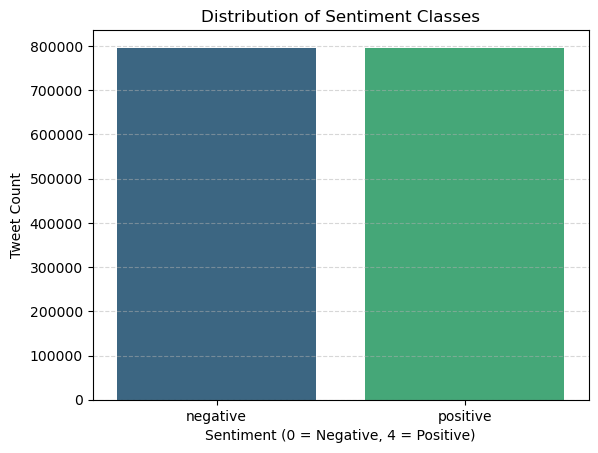

In [35]:
# Assigning x variable to both x and hue
sns.countplot(data=df, x='sentiment', hue='sentiment', palette='viridis', legend=False)

plt.title("Distribution of Sentiment Classes")
plt.xlabel("Sentiment (0 = Negative, 4 = Positive)")
plt.ylabel("Tweet Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

There are more 796,109 positive tweets and 796,297 negative tweets.

### 2.2.2 Tweet Length Distribution

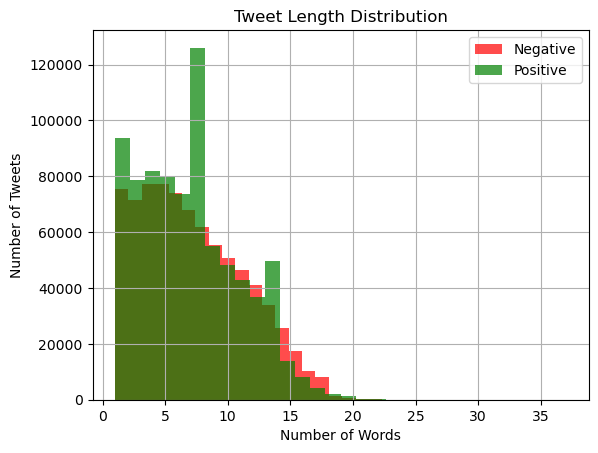

In [38]:
plt.hist(df[df['sentiment'] == 'negative']['text_length'], bins=30, alpha=0.7, label='Negative', color='red')
plt.hist(df[df['sentiment'] == 'positive']['text_length'], bins=30, alpha=0.7, label='Positive', color='green')
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Tweets")
plt.legend()
plt.grid(True)
plt.show()

This histogram shows the distribution of tweet lengths (in number of words) for positive and negative tweets:
- Most tweets, both positive (green) and negative (red) are between 2 and 10 words long.

- Positive tweets appear more frequently in shorter lengths (especially around 4 and 8 words).

- There is a steep decline in tweet counts beyond 15 words, meaning long tweets are rare.

- The overlap in bars shows that both sentiment types share a similar length pattern, but positive tweets slightly dominate at shorter lengths.

### 2.2.3 Tokenization and Word Clouds
Word clouds helps visualize the most frequent words in tweets, making it easy to identify key themes or patterns. By comparing word clouds for positive and negative tweets, we can spot language differences across sentiments and gain quick, intuitive insights before modeling.

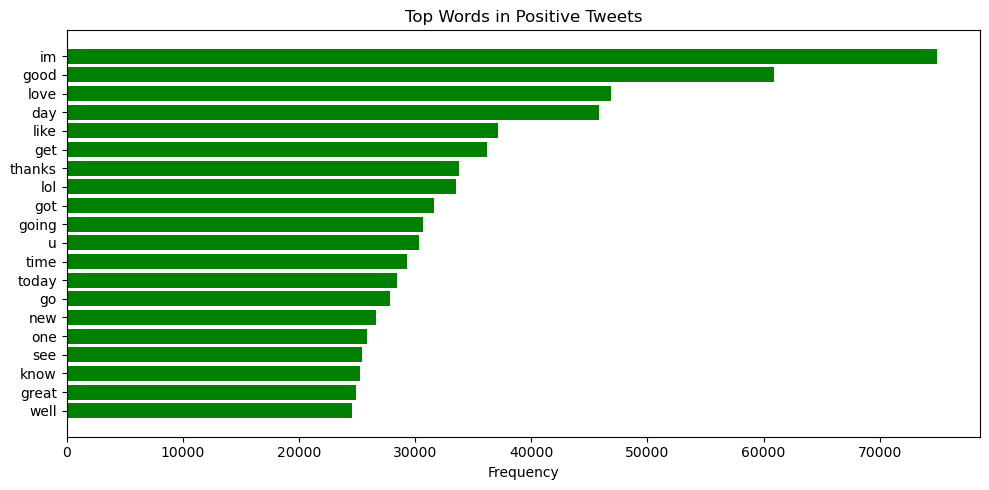

In [41]:
# Create a 'tokens' column by tokenizing the cleaned tweets
df['tokens'] = df['clean_text'].apply(word_tokenize)

# Getting top N words and their frequencies
def get_top_n_words(tokens_list, n=20):
    all_words = [word.lower() for tokens in tokens_list for word in tokens]
    return Counter(all_words).most_common(n)

# Function to plot top words for given sentiment
def plot_top_words(sentiment_label, color):
    tokens = df[df['sentiment'] == sentiment_label]['tokens']
    top_words = get_top_n_words(tokens)

    words, freqs = zip(*top_words)

    plt.figure(figsize=(10, 5))
    plt.barh(words[::-1], freqs[::-1], color=color)  # horizontal bar chart (top at top)
    plt.title(f"Top Words in {sentiment_label.capitalize()} Tweets")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

# Plot for both sentiments
plot_top_words('positive', color='green')

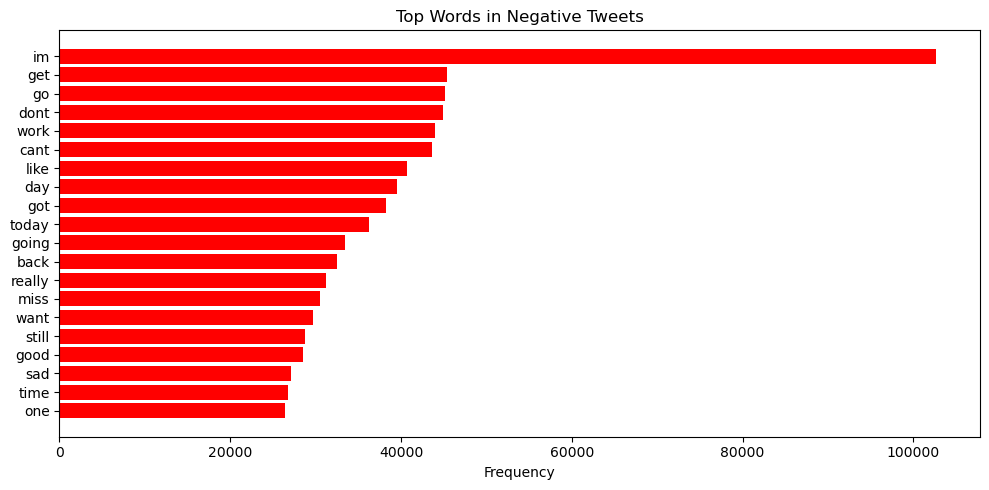

In [42]:
plot_top_words('negative', color='red')

Insights:
- Words such as "dont," "miss," "cant," "sad," "still" strongly indicate negative sentiment.
- Words like "love," "thanks," "good," "great,"well" point toward positive sentiment.

## 3.0 Modelling
In line with our business goals, we choose the below models.

### 3.1 Vectorization (TF-IDF)
Here we aim to transform clean text into numerical features that models can understand.

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])  # Feature matrix
y = df['sentiment']                             # Target variable (0 or 4)

### 3.2 Train-Test Split

In [48]:
from sklearn.model_selection import train_test_split 

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 3.2 Logistic Regression
Logistic regression is simple, fast, and interpretable, making it perfect as a baseline model for binary classification tasks like sentiment analysis.

Strengths:
- Great for high-dimensional sparse data (like TF-IDF vectors).
- Gives Outputs probabilities useful for threshold tuning and business decision-making.
- Coefficients help with model explainability (feature importance).

### Import Libaries

In [51]:
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### Instantiate Model

In [53]:
# Instantiate and train the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict on test set
y_pred_logreg = logreg.predict(X_test)

### Evaluate Logistics Regression Model

In [55]:
# Evaluate the model
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

Logistic Regression Results:
[[118105  41155]
 [ 33175 126047]]
              precision    recall  f1-score   support

    negative       0.78      0.74      0.76    159260
    positive       0.75      0.79      0.77    159222

    accuracy                           0.77    318482
   macro avg       0.77      0.77      0.77    318482
weighted avg       0.77      0.77      0.77    318482

Accuracy: 0.7666116138431686


### Logistic Regression Model Interpretation:
_____
**1. Confusion Matrix:**

- **True Negatives(TN):** 118,105 Negative tweets correctly predicted as negative

- **False Positives(FP):** 41,155 Negative tweets incorrectly predicted as positive

- **False Negatives(FN):** 33,175 Positive tweets incorrectly predicted as negative

- **True Positives(TP):** 126,047 Positive tweets correctly predicted as positive

**2. Classification Report Metrics:**

Macro & Weighted Averages (0.77) suggest balanced performance across both classes.

| Metric    | Negative Class (0) | Positive Class (4) | What It Means                                                  |
| --------- | ------------------ | ------------------ | -------------------------------------------------------------- |
| Precision | 0.78               | 0.75               | % of predicted negatives/positives that were correct.          |
| Recall    | 0.74               | 0.79               | % of actual negatives/positives the model captured.            |
| F1-Score  | 0.76               | 0.77               | Harmonic mean of precision and recall – overall effectiveness. |


**3. Accuracy 76.7%:** This means the model correctly predicted the sentiment in 77 out of every 100 tweets.

**4. Business Interpretation:**

**Strength:**

The model performs consistently across both sentiment classes, with only minor differences in precision/recall between positive and negative.

**Use Case Fit:** 

For monitoring real-time sentiment, The balance between precision and recall ensures both praise and complaints are captured reasonably well.

**Improvement Opportunities:** 

Misclassifications (FP + FN) total 74,000 tweets. Advanced techniques like deep learning or transformer models could reduce this.
____

## 3.3 Multinomial Naive Bayes
The Naive Bayes model is specifically built for text classification problems using word frequencies, making it excellent for sparse data with low variance.

Strengths:
- Very fast even on large datasets.
- Performs surprisingly well with independent word assumptions, especially for spam/sentiment problems.
- Works naturally with count-based or TF-IDF features.

### Import Libraries

In [59]:
from sklearn.naive_bayes import MultinomialNB

### Instantiate model

In [61]:
# Instantiate and train the Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Predict on test set
y_pred_nb = nb.predict(X_test)

### Evaluate Naive Bayes model

In [63]:
print("Naive Bayes Results:")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Results:
[[120458  38802]
 [ 39921 119301]]
              precision    recall  f1-score   support

    negative       0.75      0.76      0.75    159260
    positive       0.75      0.75      0.75    159222

    accuracy                           0.75    318482
   macro avg       0.75      0.75      0.75    318482
weighted avg       0.75      0.75      0.75    318482

Accuracy: 0.7528180556514968


### Naive Bayes Classifier Interpretation:
_____
**1. Confusion Matrix:**
- **True Negatives(TN):** 120,458 Negative tweets correctly predicted as negative

- **False Positives(FP):** 38,802 Negative tweets incorrectly predicted as positive

- **False Negatives(FN):** 39,921 Positive tweets incorrectly predicted as negative

- **True Positives(TP):** 119,301 Positive tweets correctly predicted as positive

**2. Classification Report Metrics:**
Both classes have balanced performance:
- **Precision:** the 75% of predicted sentiments were actually correct): for both classes
- **Recall:** the 75% actual sentiments were correctly predicted): for both classes
- **F1-Score(0.75):** overall balance between precision and recall) is good, but lower than Logistic Regression)


**3. Accuracy 75.3%:** This means the model correctly predicted the sentiment of tweets about 3 out of every 4 times.

**4. Business Interpretation:**
- Naive Bayes performed decently and is fast and efficient, making it a good baseline model. However, its assumptions (like word independence) might limit its ability to model deeper context and nuance in tweets.
- It slightly underperformed compared to Logistic Regression, which had 76.6% accuracy and higher recall/precision.
____

## 3.4 Random Forest Model
Random forest is powerful non-linear model that adds depth and complexity, captures non-linear relationships, and is robust to overfitting. 

Strengths:
- Captures complex interactions between words/features.
- Resistant to overfitting via ensemble averaging.
- Provides feature importance for insight into which terms matter most.

### Import Libraries

In [67]:
from sklearn.ensemble import RandomForestClassifier

### Random Forest on Smaller Dataset (500K Tweets)

In [69]:
#  Sampling 500,000 rows from the main DataFrame for faster model training
df_sample = df.sample(n=500000, random_state=42)

# Defining features and labels from the sampled dataset
X_sample_text = df_sample['clean_text']   # Feature text
y_sample = df_sample['sentiment']         # Labels (target variable)

# TF-IDF Vectorization on the sampled tweets
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(X_sample_text)  # Convert text to numerical feature vectors
y = y_sample                                 # Set target labels

### Train-test split 

In [71]:
# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Instantiate model

In [73]:
# Instantiate the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict sentiment labels on the test set
y_pred_rf = rf.predict(X_test)

### Evaluate Radom Forest model

In [75]:
# Evaluate the model
print("Random Forest Results (500K Sample):")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Results (500K Sample):
[[37111 12766]
 [12075 38048]]
              precision    recall  f1-score   support

    negative       0.75      0.74      0.75     49877
    positive       0.75      0.76      0.75     50123

    accuracy                           0.75    100000
   macro avg       0.75      0.75      0.75    100000
weighted avg       0.75      0.75      0.75    100000

Accuracy: 0.75159


### Random Forest Classifier Interpretation:
_____
**1. Confusion Matrix:**
- **True Negatives(TN):** 37111 Negative tweets correctly predicted as negative

- **False Positives(FP):** 12,766 Negative tweets incorrectly predicted as positive

- **False Negatives(FN):** 12075 Positive tweets incorrectly predicted as negative

- **True Positives(TP):** 38048 Positive tweets correctly predicted as positive

**2. Classification Report Metrics:**
Both classes have balanced performance:
- **Precision:** the 75% of predicted sentiments were actually correct for both classes
- **Recall:** the 75% actual sentiments were correctly predicted for both classes
- **F1-Score(0.75):** overall balance between precision and recall is good, but lower than Logistic Regression


**3. Accuracy 75.2%:** This means the model correctly predicted the sentiment of tweets about 3 out of every 4 times.

**4. Business Interpretation:**
- It slightly underperformed compared to Logistic Regression, which had 77% accuracy and higher recall/precision.
____

## 3.5 Feature Importance Plot for Random Forest 

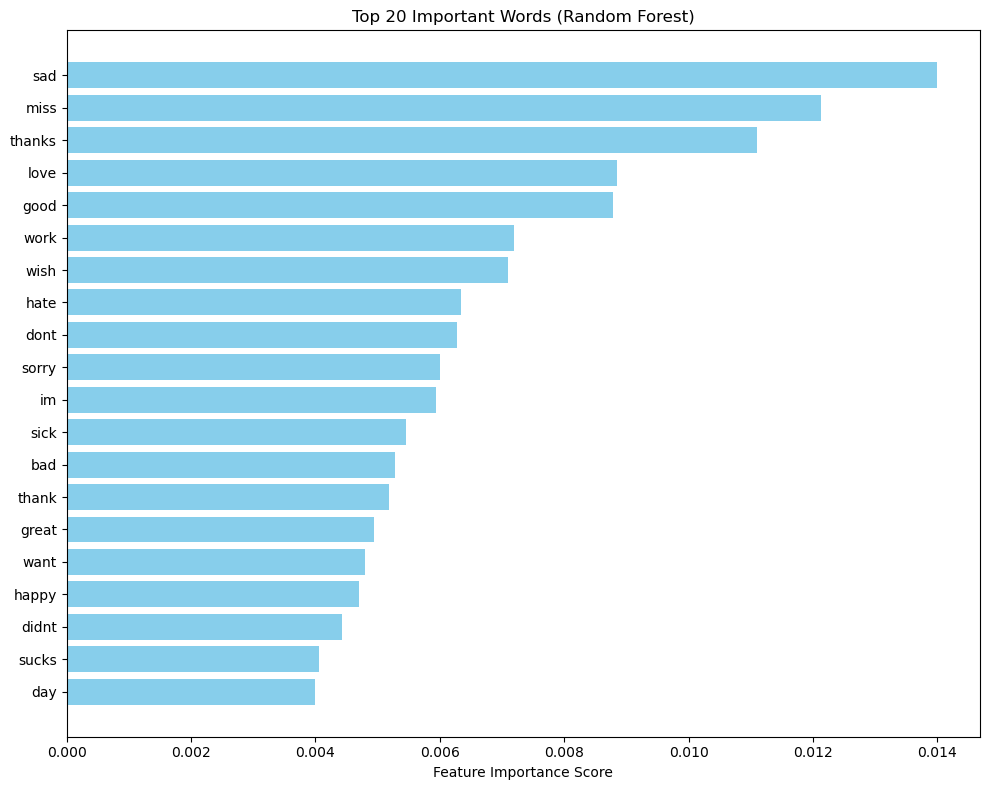

In [78]:
# Getting feature names from TF-IDF
feature_names = vectorizer.get_feature_names_out()

# Get importances and sort
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 important features

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], align="center", color='skyblue')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 20 Important Words (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()

The chart shows the Top 20 most important words(features) used by the Random Forest model to classify tweets as either positive or negative.

- **X-axis:** Feature importance score — this indicates how influential a word is in determining the sentiment.
- **Y-axis:** Words (features) extracted from tweets using TF-IDF vectorization.
- A **higher bar** means that the word has a stronger influence on the model's prediction.

#### Insights:
- Words such as **"sad," "miss," "hate," "sick," "sucks"** strongly indicate **negative sentiment**.
- Words like **"love," "thanks," "good," "great," "happy"** point toward **positive sentiment**.
- The Random Forest model uses these word patterns to make informed classification decisions.

#### Importance
- Helps us **understand what the model has learned**.
- Provides **transparency** into model behavior, which is crucial for business stakeholders.
- Can guide future **feature engineering or model refinement** (e.g. focusing on impactful words).

This analysis strengthens model interpretability and ensures we're aligned with the business goal of monitoring sentiment effectively.
____

## 3.6 Hyperparameter Tuning with GridSearchCV for Logistic Regression

GridSearchCV helps us find the best hyperparameters for our model by testing different combinations using cross-validation. This improves model performance and avoids guesswork, making our model more accurate and reliable.

In [81]:
from sklearn.model_selection import GridSearchCV

# Defining the model
logreg = LogisticRegression(solver='liblinear')  

# Defining the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],            # Regularization strength
    'penalty': ['l1', 'l2']             # Type of regularization
}

# Setting up GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=3,                               # 3-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Show best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'C': 1, 'penalty': 'l1'}
Best Cross-Validated Accuracy: 0.762089995659537


### Evaluate the model 

In [83]:
# Evaluate the best model on test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Classification Report (Best Logistic Regression):")
print(classification_report(y_test, y_pred_best))
print("Accuracy:", accuracy_score(y_test, y_pred_best))

Classification Report (Best Logistic Regression):
              precision    recall  f1-score   support

    negative       0.78      0.74      0.76     49877
    positive       0.75      0.79      0.77     50123

    accuracy                           0.76    100000
   macro avg       0.77      0.76      0.76    100000
weighted avg       0.77      0.76      0.76    100000

Accuracy: 0.76471


____
**Classification Report Summary:**
- **Accuracy:** 76.47% — the model correctly predicted the class for about 76 out of every 100 samples.

- **Precision:**

   - Negative class: 78% of predicted negatives were correct.

   - Positive class: 75% of predicted positives were correct.

- **Recall:**

   - Negative class: 74% of actual negatives were identified correctly.

   - Positive class: 79% of actual positives were identified correctly.

**F1-Score** (balance between precision and recall):

   - Around 0.76–0.77 for both classes, indicating consistent performance.

**Interpretation:**
The tuned Logistic Regression model performs fairly well on both classes, with a balanced trade-off between precision and recall. GridSearchCV helped optimize the model, resulting in better generalization on unseen data.
____

## 3.7 Model Metric Comparison: Choosing Best fit Model

We’re doing model comparison to identify which algorithm performs best on our sentiment classification task, helping us choose the most accurate, reliable, and efficient model for real-world business use.

### 3.7.1 Train-Test Split on Sampled Dataset (500,000 rows)

In [87]:
# sampling 500k rows
df_sample = df.sample(n=500000, random_state=42)

X_sample_text = df_sample['clean_text']
y_sample = df_sample['sentiment']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_sample = vectorizer.fit_transform(X_sample_text)

# Final train-test split for ALL models
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

### 3.7.2 Retraining and Predicting for Each Model Using the SAME Sampled Split

In [89]:
# 1. Logistic Regresstion
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_sample, y_train_sample)
y_pred_logreg = logreg.predict(X_test_sample)

In [90]:
# 2. Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_sample, y_train_sample)
y_pred_nb = nb.predict(X_test_sample)

In [91]:
# 3. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sample, y_train_sample)
y_pred_rf = rf.predict(X_test_sample)

In [100]:
# Ensure all predictions are done on X_test_sample and y_test_sample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": y_pred_logreg,
    "Naive Bayes": y_pred_nb,
    "Random Forest": y_pred_rf
}

metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Looping through each model's predictions
for model_name, y_pred in models.items():
    metrics["Model"].append(model_name)
    metrics["Accuracy"].append(accuracy_score(y_test_sample, y_pred))
    metrics["Precision"].append(precision_score(y_test_sample, y_pred, pos_label='positive'))
    metrics["Recall"].append(recall_score(y_test_sample, y_pred, pos_label='positive'))
    metrics["F1-Score"].append(f1_score(y_test_sample, y_pred, pos_label='positive'))

# Converting to DataFrame for display
results_df = pd.DataFrame(metrics)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression   0.76408   0.752239  0.789278  0.770314
1          Naive Bayes   0.75224   0.747071  0.764539  0.755704
2        Random Forest   0.75159   0.748770  0.759093  0.753896


### 3.7.3. Visualizing our Best fit Model

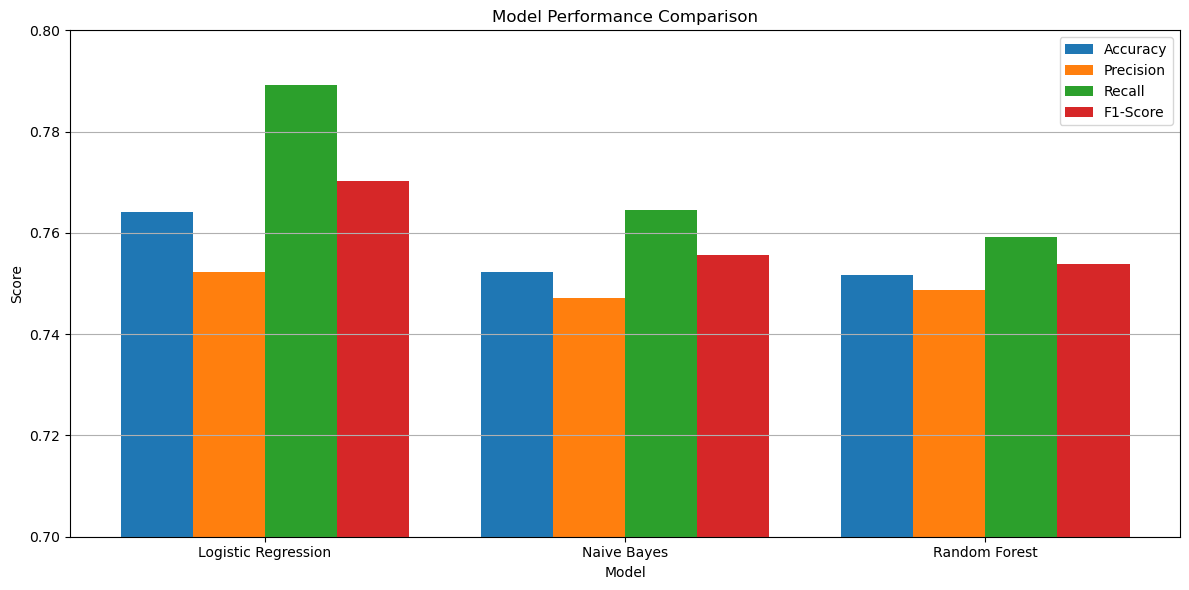

In [102]:
# Plot setup
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(results_df))

# Plotting bars for each metric
plt.bar([i - bar_width*1.5 for i in index], results_df['Accuracy'], bar_width, label='Accuracy')
plt.bar([i - bar_width/2 for i in index], results_df['Precision'], bar_width, label='Precision')
plt.bar([i + bar_width/2 for i in index], results_df['Recall'], bar_width, label='Recall')
plt.bar([i + bar_width*1.5 for i in index], results_df['F1-Score'], bar_width, label='F1-Score')

# Labeling
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(index, results_df['Model'])
plt.ylim(0.7, 0.8)  # Optional: adjust based on scores
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Model Comparison Interpretation

We evaluated three machine learning models for tweet sentiment classification: Logistic Regression, Naive Bayes, and Random Forest. The models were assessed using four key metrics: Accuracy, Precision, Recall, and F1-Score.

- **Logistic Regression** performed the best overall, achieving the highest accuracy (76.4%), recall (78.9%), and F1-score (77%).

- **Naive Bayes** was slightly behind, showing solid precision but lower recall than Logistic Regression.

- **Random Forest** despite its complexity, performed similarly to Naive Bayes, but did not outperform Logistic Regression.

The bar chart visualization clearly shows Logistic Regression’s consistent lead across all metrics, making it the most reliable model in this scenario.

### 3.7.4 Confusion Matrix Plot Code for All 3 Models

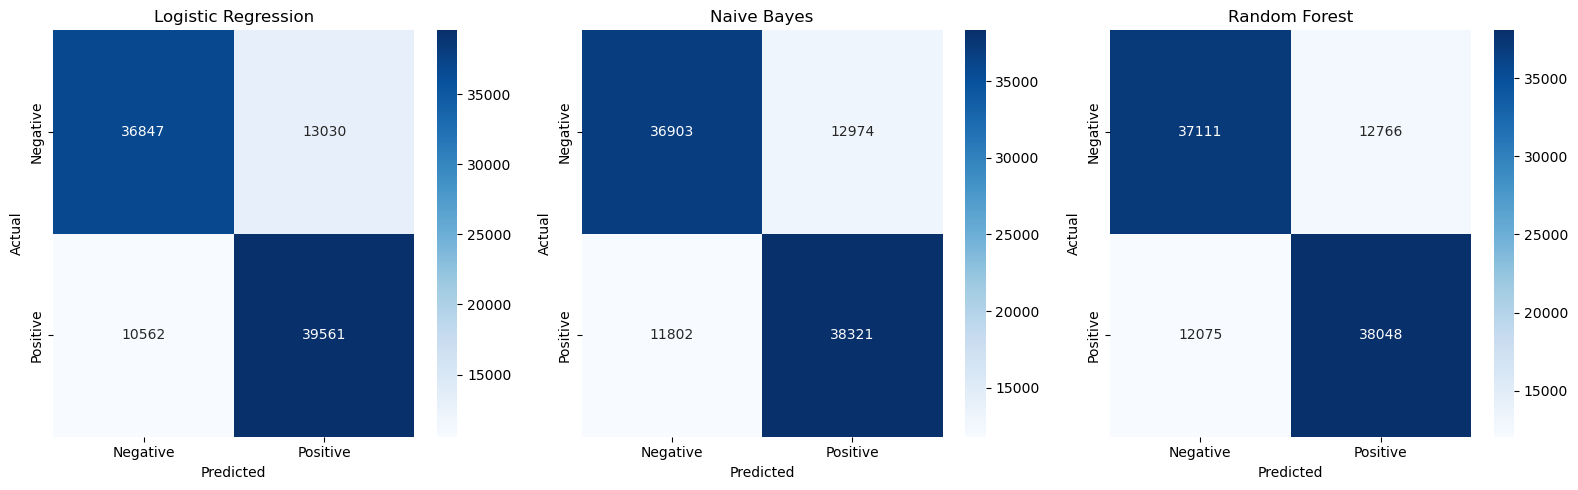

In [104]:
from sklearn.metrics import confusion_matrix

# Creating a 1x3 subplot for 3 models
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Defining titles and predictions
model_titles = ['Logistic Regression', 'Naive Bayes', 'Random Forest']
model_preds = [y_pred_logreg, y_pred_nb, y_pred_rf]
true_labels = y_test_sample

# Loop to create each confusion matrix plot
for i, (title, preds) in enumerate(zip(model_titles, model_preds)):
    cm = confusion_matrix(true_labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'], ax=axes[i])
    axes[i].set_title(f'{title}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

Based on both the quantitative metrics and visual comparison, Logistic Regression is the best-performing model for this sentiment analysis task. It balances precision and recall well, making it ideal for real-world deployment where both false positives and false negatives matter.

## 4. Error Analysis of Misclassified Tweets

### 4.1 Identify Misclassified Tweets
In this step We’ll compare y_test_sample vs each model's predictions and extract where they differ.

In [106]:
# Split raw text and labels 
X_sample_text_train, X_sample_text_test, y_train_sample, y_test_sample = train_test_split(
    df_sample['clean_text'], df_sample['sentiment'], test_size=0.2, random_state=42, stratify=df_sample['sentiment']
)

# Refit vectorizer on training set and transform both
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = vectorizer.fit_transform(X_sample_text_train)
X_test = vectorizer.transform(X_sample_text_test)

X_test_sample_text = X_sample_text_test.reset_index(drop=True) 

In [108]:
error_df = pd.DataFrame({
    'text': X_test_sample_text,  
    'true_label': y_test_sample.reset_index(drop=True),
    'logreg_pred': y_pred_logreg,
    'nb_pred': y_pred_nb,
    'rf_pred': y_pred_rf
})

# Filter misclassified tweets by Logistic Regression
logreg_errors = error_df[error_df['true_label'] != error_df['logreg_pred']]
logreg_errors.head(10)

,text,true_label,logreg_pred,nb_pred,rf_pred
1,aww keep trying youre likely something wrong i...,positive,negative,negative,positive
5,im taking lyrics say world humanity slowly dec...,negative,positive,positive,positive
6,feel bad im really glad schools keep amazing w...,positive,negative,negative,negative
8,hollie steel bgt absolutely excruciating watch...,negative,positive,positive,positive
10,man good friends hard come bylong distance bes...,negative,positive,positive,positive
12,age perfected evil eye look,positive,negative,negative,positive
21,wattup u friend,negative,positive,positive,positive
22,listening hillsong united miss songs,positive,negative,positive,negative
24,oscar thinks fly jumped counter top ok fear,negative,positive,negative,positive
39,brazilian fans,negative,positive,positive,positive


The result shows tweets where Logistic Regression got the prediction wrong.

### Error Analysis

After evaluating model performance with metrics like precision and recall, we went deeper by examining individual **misclassified tweets**. 

- **False Positives** reveal cases where the model incorrectly predicted positive sentiment for a negative tweet, often due to sarcasm or misleading keywords.
- **False Negatives** indicate that the model missed a positive sentiment, possibly due to informal language, misspellings, or the absence of strong sentiment words.

This analysis helps pinpoint limitations in the model’s understanding of context, suggesting that future work could explore:
- More advanced models like BERT
- Incorporating emojis, hashtags, or punctuation into features
- Handling sarcasm and irony
_____

## 5. Project Conclusion
- This project successfully demonstrated how natural language processing (NLP) techniques can be applied to automate sentiment classification of tweets. Using the large-scale Sentiment140 dataset, we implemented a robust pipeline, from data preprocessing and exploratory data analysis (EDA) to vectorization, model training, evaluation, and error analysis.

- Based on both the quantitative metrics and visual comparison, Logistic Regression is the best-performing model for this sentiment analysis task. It balances precision and recall well, making it ideal for real-world deployment where both false positives and false negatives matter.

## 6. Summary
We had the following key achievements in the project: 

**1. Data Preparation:**

Cleaned 1.6M tweets by removing noise, stopwords, and punctuation. Tokenization and normalization ensured the text was ready for modeling.

**2. EDA Insights:**
- Positive and negative sentiments were evenly distributed.
- Word clouds and token frequency visualizations highlighted common emotional expressions.
- Tweet length distributions showed that most tweets range between 10–25 words.

**3.Modeling:**
- Applied TF-IDF vectorization to extract meaningful features.
- Trained and compared three models:
    - Logistic Regression (Best performer: 76.4% accuracy)
    - Naive Bayes (75.2% accuracy)
    - Random Forest (75.1% accuracy on sampled data)
- Hyperparameter tuning with GridSearchCV was conducted to optimize Logistic Regression.

**4. Model Comparison & Interpretation:**
- **Logistic Regression** achieved the highest F1-score and recall, making it the most effective for detecting positive sentiments.
- Evaluation metrics such as confusion matrices and precision-recall helped assess model reliability.

**5. Error Analysis:**
- Extracted misclassified tweets revealed limitations where models struggled with sarcasm, ambiguous context, or informal language.
- These cases highlighted the potential for future improvement using advanced NLP techniques (e.g.BERT or LSTM).

**6. Business Value:**
This solution provides a scalable, interpretable, and near real-time tool for sentiment monitoring—empowering businesses to understand public opinion, track brand sentiment, and enhance decision-making based on social media feedback.
_____

## 7. Recommendations and Next Steps

______
### a) Recommendations
**1. Adopt Logistic Regression for Deployment**
- Given its strong balance of performance and efficiency, Logistic Regression is the best initial model to deploy for real-time tweet sentiment classification.

**2. Expand to Include Neutral Class**
- While this project focused on binary classification (positive vs. negative), incorporating neutral tweets would provide a more complete sentiment spectrum, especially for nuanced brand or product analysis.

**3. Monitor Misclassifications**
- Regularly analyze misclassified tweets to identify edge cases (e.g. sarcasm, slang) and use this insight to refine preprocessing or introduce additional features.

**4. Optimize for Speed and Scale**
- Given the size of tweet streams in production, future iterations should focus on model optimization for speed, especially when using Random Forest or deep learning models.
_____

### b) Next Steps
**1. Implement Deep Learning Models (BERT, LSTM)**
- Upgrade to more advanced NLP models like BERT or BiLSTM to handle context and semantic understanding, especially for tweets that are ambiguous or sarcastic.

**2. Real-Time Sentiment Dashboard**
- Build a live dashboard using Streamlit, Power BI or Tableau for stakeholders to visualize tweet trends and sentiment in real time.

**3. Integrate Topic Modeling (LDA/NMF)**
- Identify key topics driving sentiment using topic modeling. This helps uncover what users are talking about, not just how they feel.

**4. Geolocation and Time-Based Analysis**
- Extend the project by including geo-tagged tweets or timestamps to track how sentiment shifts over time or by region.

**5. API Deployment**
- Package the model with a simple Flask or FastAPI interface for integration into applications or customer feedback systems.
_____

## Acknowledgment
We would like to express our sincere gratitude to:
- Moringa School for providing a solid foundation in data science and NLP through practical coursework and mentorship.
- The creators of the Sentiment140 dataset; Alec Go, Richa Bhayani, and Lei Huang whose work enabled this analysis.
- The broader open-source community and tools like NLTK, Scikit-learn, and Matplotlib, which made it possible to carry out this end-to-end project.
- Our instructor Mildred Jepkosgei who offered feedback, encouragement, and technical guidance throughout this phase.

Their contributions and support have been instrumental in the successful completion of this work.

## Authors
- Pamela Godia

- Austine Otieno

- Allan Ofula